<a href="https://colab.research.google.com/github/K28Ayra/CAMLab-DLSCTutorials/blob/main/lipnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python matplotlib gdown imageio tensorflow

In [ ]:
!pip list


Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.10.1
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.12.15
aiosignal                                1.4.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.16.5
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                                0.9.18
argon2-cffi                              25.1.0
argon2-cffi-bindings              

In [2]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imageio
from typing import List
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_dev=tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_dev[0], True)
except:
  pass



  #avoid exponential memory growth

# **Data Loading Functions**

In [5]:
import gdown    #will go directly to drive to grab the data

In [6]:
import gdown
import zipfile
import os


#annotations
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output_zip = 'data.zip'

# Download
gdown.download(url, output_zip, quiet=False)

# Unzip
if os.path.exists(output_zip):
  with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall() # Extracts to the current directory
    print("File extracted successfully!")

  # os.remove(output_zip)
else:
  print(f"Error: {output_zip} not found. Download may have failed.")

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=767be951-17a3-4621-98d6-b58285de6351
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 131MB/s]


File extracted successfully!


In [7]:
!ls

 data   data.zip  'LipNet (1).ipynb'   sample_data


In [8]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])#extract the mouth portion, original paper uses DLip
    cap.release()


    #standardize
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std



In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]



In [10]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
#tokenize- conversion
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [12]:
char_to_num(['a','y','r','a'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 25, 18,  1])>

In [13]:
num_to_char([ 1, 25, 18,  1])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'y', b'r', b'a'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]



In [15]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #linux path separator, bcz colab runs on linux env
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [17]:

test_path = './data/s1/bbal6n.mpg'

In [18]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.460374  ],
          [ 1.460374  ],
          [ 1.4209044 ],
          ...,
          [ 0.15787826],
          [ 0.19734783],
          [ 0.07893913]],
 
         [[ 1.460374  ],
          [ 1.460374  ],
          [ 1.4209044 ],
          ...,
          [ 0.15787826],
          [ 0.07893913],
          [ 0.03946957]],
 
         [[ 1.4209044 ],
          [ 1.4209044 ],
          [ 1.3814349 ],
          ...,
          [ 0.07893913],
          [ 0.07893913],
          [ 0.07893913]],
 
         ...,
 
         [[ 0.9472696 ],
          [ 0.9472696 ],
          [ 0.9472696 ],
          ...,
          [ 9.946331  ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.9472696 ],
          [ 0.9472696 ],
          [ 0.9472696 ],
          ...,
          [ 9.906861  ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.9472696 ],
          [ 0.9472696 ],
          [ 0.9472696 ],
          

In [19]:

tf.convert_to_tensor(test_path).numpy()

b'./data/s1/bbal6n.mpg'

In [20]:
#unpack the path
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')

['.', 'data', 's1', 'bbal6n.mpg']

In [23]:
#-1 is the last value ie the file name
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [24]:
frames, alignments= load_data(tf.convert_to_tensor(test_path))

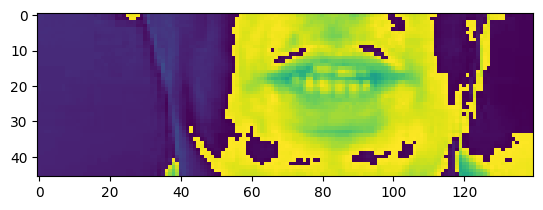

In [25]:
plt.imshow(frames[40])

In [26]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [27]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [28]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

#   DATA PIPELINE

In [29]:
from matplotlib import pyplot as plt

In [61]:
#DATASET
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
#data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.padded_batch(2, padded_shapes=([75, 46, 140, 1], [40]))
#pad bcz of different size
#75 frames for each video, 40 token for each of alignmnets
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)



In [62]:

len(test)

50

In [63]:

frames, alignments = data.as_numpy_iterator().next()

In [64]:
len(frames)

2

In [65]:
sample=data.as_numpy_iterator()


In [66]:
val = sample.next(); val[0]

array([[[[[1.3577439 ],
          [1.3577439 ],
          [1.3189512 ],
          ...,
          [9.736963  ],
          [0.19396341],
          [0.19396341]],

         [[1.3577439 ],
          [1.3577439 ],
          [1.3189512 ],
          ...,
          [9.853341  ],
          [0.19396341],
          [0.15517074]],

         [[1.2801585 ],
          [1.2801585 ],
          [1.2801585 ],
          ...,
          [0.2327561 ],
          [0.19396341],
          [0.19396341]],

         ...,

         [[0.85343903],
          [0.85343903],
          [0.85343903],
          ...,
          [9.659378  ],
          [9.620585  ],
          [9.620585  ]],

         [[0.85343903],
          [0.85343903],
          [0.85343903],
          ...,
          [9.426622  ],
          [9.465415  ],
          [9.504208  ]],

         [[0.85343903],
          [0.85343903],
          [0.85343903],
          ...,
          [9.543     ],
          [9.620585  ],
          [9.465415  ]]],


        [[[1.3577

In [ ]:
#to gif

# **NEURAL NETWORK**

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [68]:
data.as_numpy_iterator().next()[0][0].shape




(75, 46, 140, 1)

In [69]:
# model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(256, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(75, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# #model.add(TimeDistributed(Flatten()))
# model.add(Reshape((75, 6375)))

# #op has 256 layers of lstm bcz its bidirectional- 128*2=256
# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))





model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))



In [70]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
print(char_to_num.vocabulary_size())

40


In [72]:
yhat= model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


In [73]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b"ziiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii'''''''''''''''''''''''''iii">

In [74]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b"ziiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii'''''''''''''''''''''''''iii">

In [75]:
model.input_shape

(None, 75, 46, 140, 1)

In [76]:
model.output_shape

(None, 75, 41)

# **Training**

In [77]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [78]:
#ctc loss
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [79]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [80]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [81]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)



In [82]:
schedule_callback = LearningRateScheduler(scheduler)


In [83]:

example_callback = ProduceExample(test)

In [85]:

model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Expected begin, end, and strides to be 1D equal size tensors, but got shapes [1], [3], and [3] instead. [Op:StridedSlice] name: strided_slice/

# **PREDICTION**

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')


In [ ]:
model.load_weights('models/checkpoint')
#model.load_weights(os.path.join('models','checkpoint.weights.h5'))

In [ ]:
test_data = test.as_numpy_iterator()


In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]



In [ ]:
#test on videoo

sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]


In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
